# SCC0251 - Reconhecimento de objeto por template
Reconhecer um determinado objeto dado uma imagem template e uma imagem em que será feita a análise e destacar o objeto localizado. Os inputs serão as duas imagens e o output será a imagem com o objeto alvo destacado.

Inicialmente vamos começar gerando nossas próprias imagens de input para ir aumentando a dificuldade gradualmente, tendo como objetivo final, a fim de teste, achar a solução do jogo "onde está Wally?" dado o cenário e o Wally (podendo ser de outro cenário).



In [1]:

import numpy as np
import cv2 as cv
import imageio

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from scipy.signal import correlate2d
from scipy.signal import fftconvolve

## Imagens utilizadas


Text(0.5, 1.0, 'Birds template')

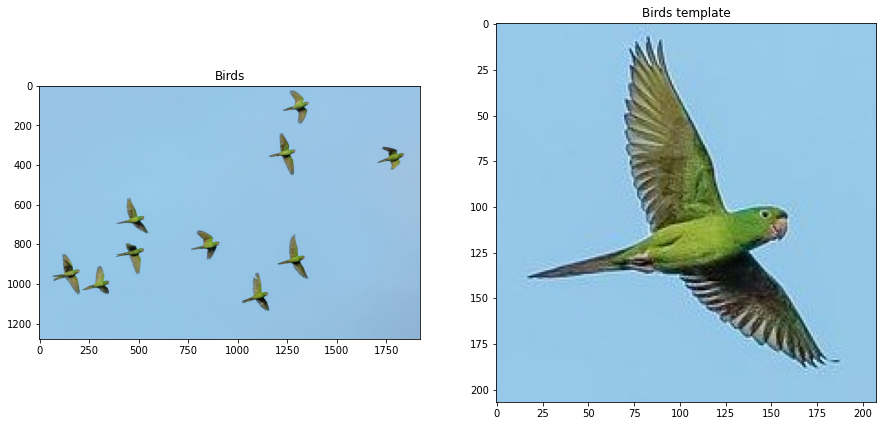

In [2]:
img_birds = imageio.imread('images/birds.jpg')
img_bird = imageio.imread('images/bird.jpg')
img_dices = imageio.imread('images/dices.jpg')
img_dice = imageio.imread('images/dice.jpg')
img_mounts = imageio.imread('images/mounts.png')
img_mount = imageio.imread('images/mount.png')
img_donuts = imageio.imread('images/donuts.png')
img_donut = imageio.imread('images/donut.png')

imgs = [[img_birds, img_bird], [img_dices,img_dice], [img_mounts, img_mount], [img_donuts, img_donut]]
imgs = np.array(imgs, dtype=object)

plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(imgs[0,0]); plt.title("Birds")
plt.subplot(122); plt.imshow(imgs[0,1]); plt.title("Birds template")

## Template Matching

Aqui vamos implementar uma solução baseada na técnica template matching usando um coeficiente de correlação (calculado usando cross-correlation normalizado entre -1 e 1) para achar o objeto desejado e destacá-lo na imagem final.

### Pré processamento necessário

Primeiramente vamos tratar a imagem para garantir que o input será como o previsto nas funções que implementamos e por isso estamos realizando a conversão de RGB para grayscale.

In [3]:
def normalize_minmax(f, factor):
    f_min = np.min(f)
    f_max = np.max(f)
    f = (f - f_min)/(f_max-f_min)
    return (f*factor)

def img_rgb_to_gray(img):
    M, N, Z = img.shape
    img_g = np.zeros((M,N))
    
    img_g = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114
    img_g = normalize_minmax(img_g, 255)
    
    return img_g

Text(0.5, 1.0, 'Template')

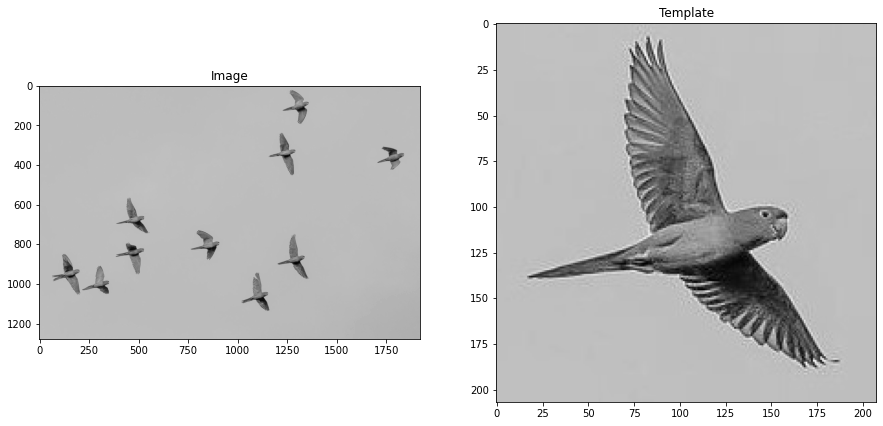

In [4]:
img = img_rgb_to_gray(imgs[0,0])
template = img_rgb_to_gray(imgs[0,1])

plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img, cmap="gray"); plt.title("Image")
plt.subplot(122); plt.imshow(template, cmap="gray"); plt.title("Template")

### Cross Correlation

Vamos implementar um método para retornar uma matriz do tamanho da imagem passada com os valores do cross-correlation normalizado entre -1 e 1. Para fazer o cálculo em cada posição da matriz é passado o template e a partição da imagem, que é do mesmo tamanho do template, e é retornado o valor (corr) sendo:
- corr = 1 => template é exatamente igual a partição da imagem 
- corr = -1 => template é exatamente a intensidade oposta da partição da imagem
- corr = 0 => sem correlação 

In [5]:
def normxcorr(image_, template_):
    image = np.array(image_, copy=True)
    template = np.array(template_, copy=True)
    
    # normaliza template e imagem
    template = template - np.mean(template)
    image = image - np.mean(image)
    mode = "same"

    a1 = np.ones(template.shape)
    
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)
    
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # Remove small machine precision errors after subtraction
    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    
    return out

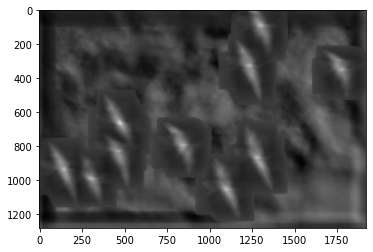

In [6]:
corr = normxcorr(img, template)

plt.imshow(corr, cmap="gray")

### Exibição 

Com a matriz de cross-correlation nas mãos, podemos adicionar um feedback visual para conferir os resultados. Escolhemos adicionar retângulos, do tamanho do template, para cada posição encontrada acima de um dado threshold (th).

In [7]:
def print_corr_img(img, corr, template, th):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

    ax1.imshow(img, cmap="gray")

    M,N = img.shape
    m,n = template.shape
    
    for x in range(M-m):
        for y in range(N-n):
            if(corr[x,y] > th):
                rect = patches.Rectangle((y-n/2,x-m/2), m,n,linewidth=3, edgecolor='r', facecolor='none')
#                 rect = patches.Circle((y,x),10,color="r")
                ax1.add_patch(rect)
        
    ax2.imshow(template, cmap="gray")

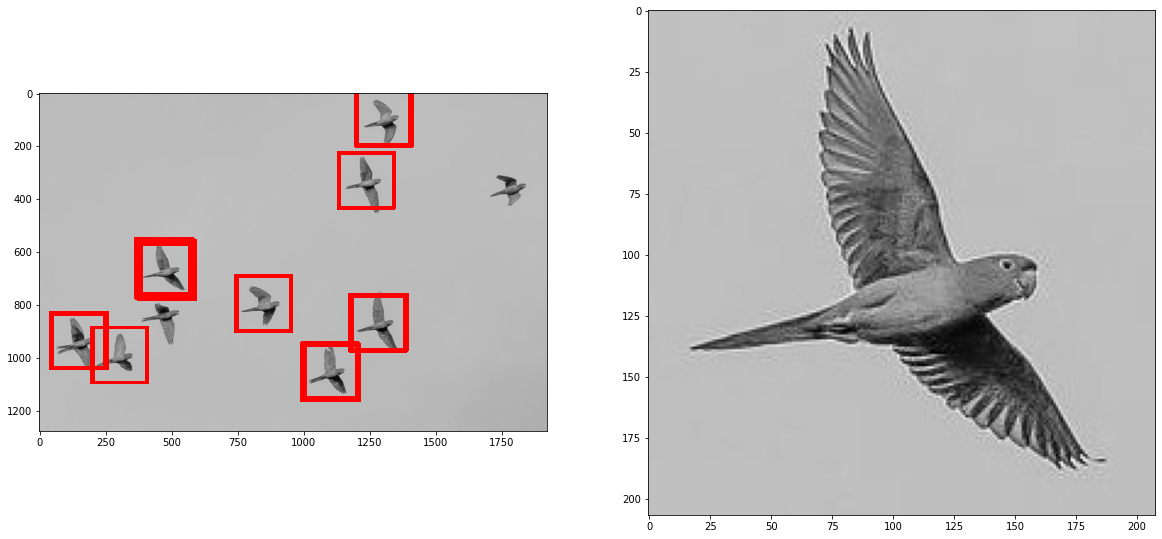

In [8]:
print_corr_img(img, corr, template, 0.6)

### Unificando

Vamos agora unificar todo o processo em um único método para facilitar a utilização futura

In [9]:
def match_template(img_, template_, th):
    img = np.array(img_, copy=True)
    template = np.array(template_, copy=True)
    
    # rgb to greyscale
    if (img.shape[-1] == 3): 
        img = img_rgb_to_gray(img)
    if (template.shape[-1] == 3): 
        template = img_rgb_to_gray(template)
    
    # cross correlation
    corr = normxcorr(img, template)
    
    # plot
    print_corr_img(img, corr, template, th)

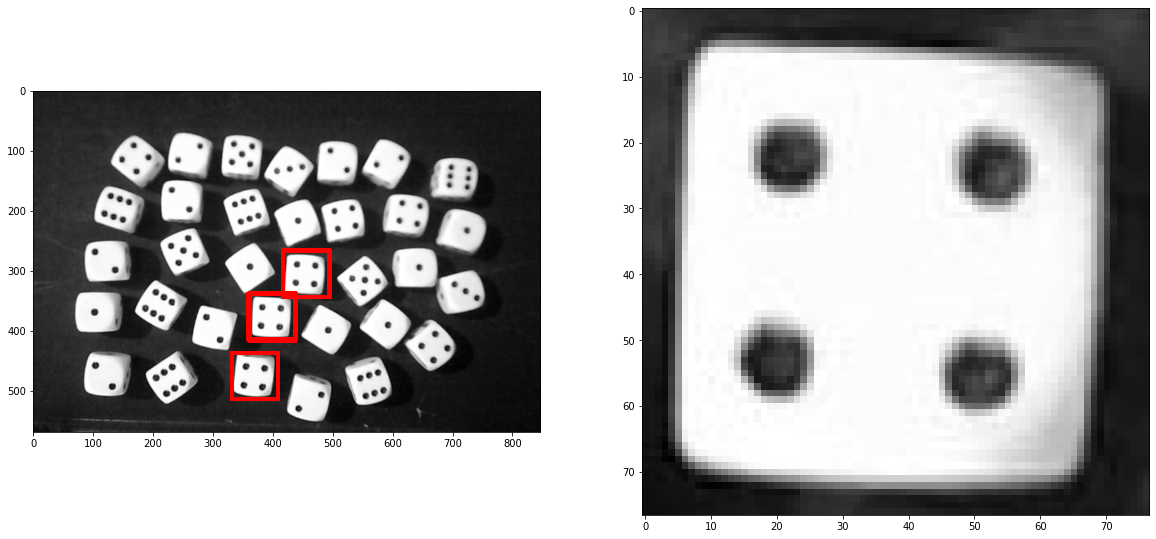

In [10]:
match_template(imgs[1,0], imgs[1,1], 0.9)

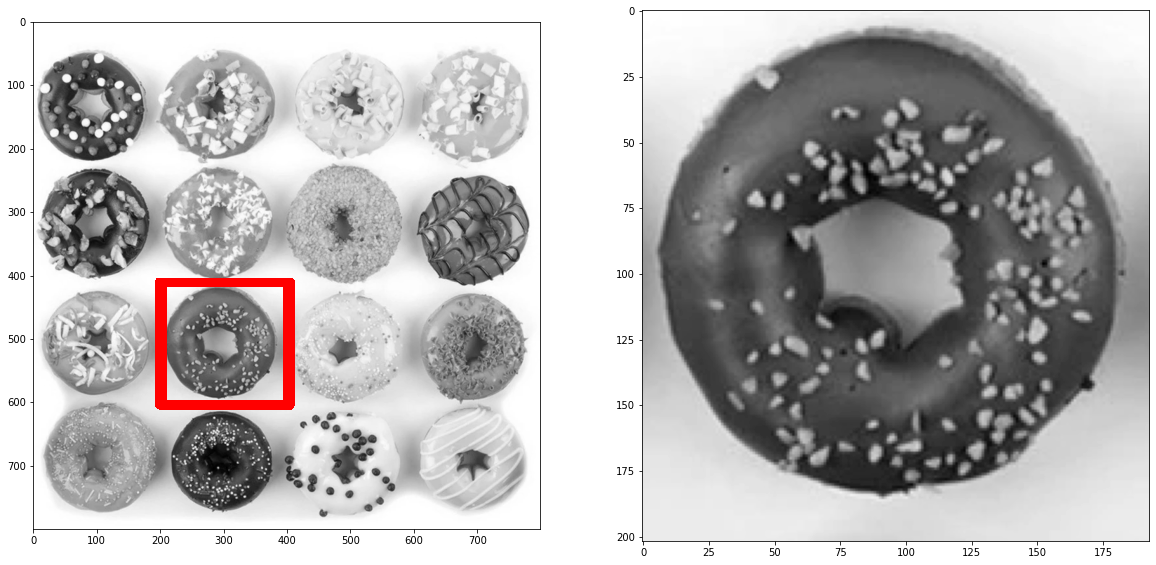

In [11]:
match_template(imgs[3,0], imgs[3,1], 0.8)

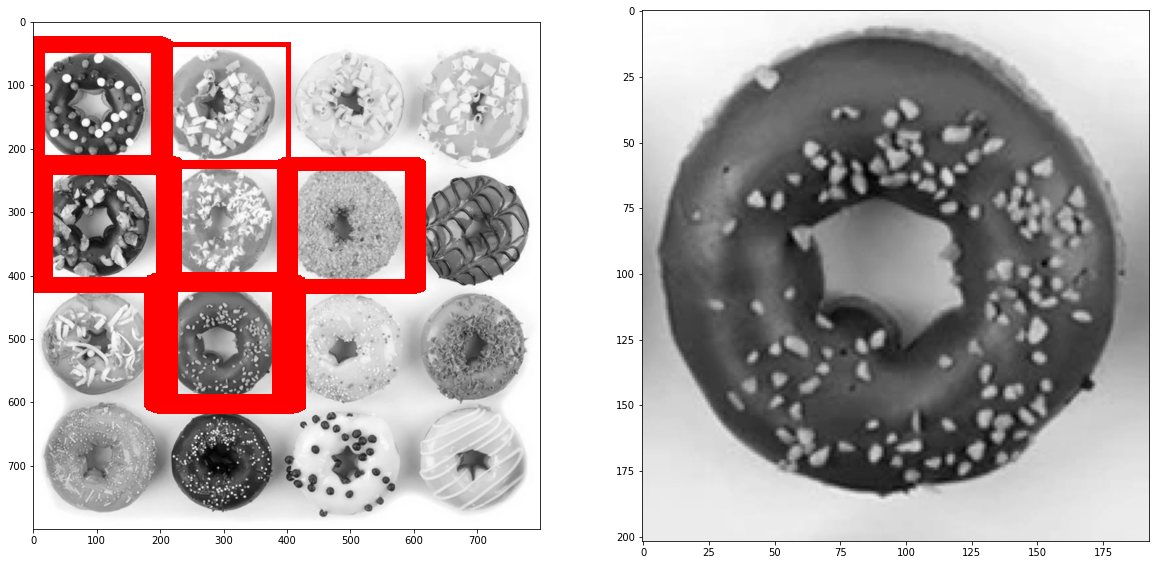

In [12]:
match_template(imgs[3,0], imgs[3,1], 0.6)